# inicialização

In [67]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
from sympy import symbols, pprint
import matplotlib.pyplot as plt
import plotly.express as px
import os
import sys

sys.path.append("..")

from structureSelector import *
#from structureSelector2 import structureSelectorV2
from methods.utils.utilities import *

def metrics(y, yest):
    residuo1 = y - yest
    index = np.where(y != 0)
    mape = round(np.mean(np.abs(residuo1[index] / y[index])) * 100, 3)
    mse = np.mean(np.square(residuo1))
    rmse = np.sqrt(mse)
    aet = np.sum(np.abs(residuo1))
    print('RMSE:', round(rmse, 4),'\nMSE:', round(mse, 4), '\nAET:', round(aet, 4), '\nMAPE:', str(round(mape, 5)) + '%')
    coeficiente_corr = np.corrcoef(y, yest)[0, 1]
    print("Coeficiente de correlação:", coeficiente_corr)
    #print(y.shape, yest.shape)

# Uniform

## preparação

In [68]:
mat_content2 = sc.loadmat("data/DATAUNIF.MAT")

print(mat_content2.keys())
u11 = mat_content2['u11']
z11 = mat_content2['z11']

u12 = mat_content2['u12']
z12 = mat_content2['z12']


t = np.arange(0, 500, 1)#np.arange(0, 10, 0.02)
fig=px.line(x=t, y=np.squeeze(z11), height=400, width=1300)
fig.add_scatter(x=t, y=np.squeeze(u11), mode='lines')
#fig.add_scatter(x=t, y=np.squeeze(zc11), mode='lines')

fig.show()

dict_keys(['u11', 'u12', 'z11', 'z12'])


## Estimação

### N abs

[Y1.1*sign(Y1.1) Y1.2*sign(Y1.1) U1.4*U1.7 U1.5**2*sign(Y1.1)
 U1.3*U1.8*Y1.3 Y1.4*sign(Y1.1) U1.10*U1.8*Y1.3] [ 1.7365842  -1.02553539  0.01532228  0.01669105  0.01008609  0.21512649
 -0.00802218] 7
-0.00802*U1.10*U1.8*Y1.3 + 0.01009*U1.3*U1.8*Y1.3 + 0.01532*U1.4*U1.7 + 0.01669*U1.5**2*sign(Y1.1) + 1.73658*Y1.1*sign(Y1.1) - 1.02554*Y1.2*sign(Y1.1) + 0.21513*Y1.4*sign(Y1.1)

Um passo a frente
RMSE: 0.043 
MSE: 0.0018 
AET: 15.0714 
MAPE: 56.547%
Coeficiente de correlação: 0.9960974999453488

Simulação livre
RMSE: 0.1564 
MSE: 0.0245 
AET: 57.3052 
MAPE: 140.793%
Coeficiente de correlação: 0.9499109734812069


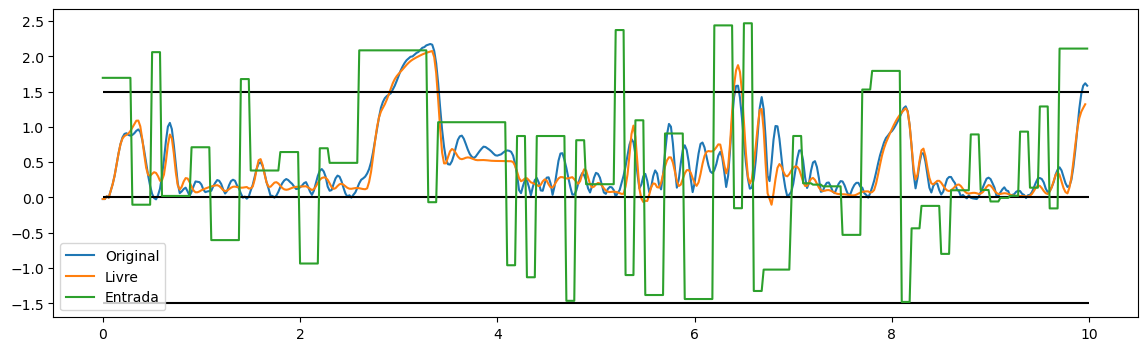

In [73]:
output = 0  # 0 ou 1

y = z11.copy()
u = u11.copy()
num = [8]#[15]#
params = []

rho = 0.000001#0.00000001#
params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,1, 0,0,0,0,0, 0],'root':False, 'delay':2, 'diff':False, "ymodifier":[0, 0]})

clip.setLimit(0, 10)
sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], rho)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta, len(model))
print(model @ np.round(theta, 5))

slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)

print("\nUm passo a frente")
metrics(y[:, 0], yhat)
print("\nSimulação livre")
metrics(y[:, 0], slivre)

fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(14, 4))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()



### gfdsg

In [ ]:
'''
[Y1.1 U1.4 U1.5*Y1.10*tanh2(Y1.1) Y1.10 U1.6 U1.3*U1.9**2 Y1.3 U1.7
 U1.10*Y1.6 U1.5**2*tanh2(Y1.1)] [ 1.09044652  0.03368588  0.02805315  0.04100245  0.0205516   0.00813204
 -0.34065918  0.02114784  0.01867876  0.00914348] 10
0.01868*U1.10*Y1.6 + 0.00813*U1.3*U1.9**2 + 0.03369*U1.4 + 0.00914*U1.5**2*tanh2(Y1.1) + 0.02805*U1.5*Y1.10*tanh2(Y1.1) + 0.02055*U1.6 + 0.02115*U1.7 + 1.09045*Y1.1 + 0.041*Y1.10 - 0.34066*Y1.3

Um passo a frente
RMSE: 0.0364 
MSE: 0.0013 
AET: 12.1319 
MAPE: 40.311%
Coeficiente de correlação: 0.9981508007817482

Simulação livre
RMSE: 0.0852 
MSE: 0.0073 
AET: 31.3717 
MAPE: 92.878%
Coeficiente de correlação: 0.989949982501234
'''

## Validação


Simulação livre
RMSE: 0.2469 
MSE: 0.0609 
AET: 86.4975 
MAPE: 99.073%
Coeficiente de correlação: 0.9525072001368533

Um passo a frente
RMSE: 0.0458 
MSE: 0.0021 
AET: 16.2636 
MAPE: 29.29%
Coeficiente de correlação: 0.9984307060090469


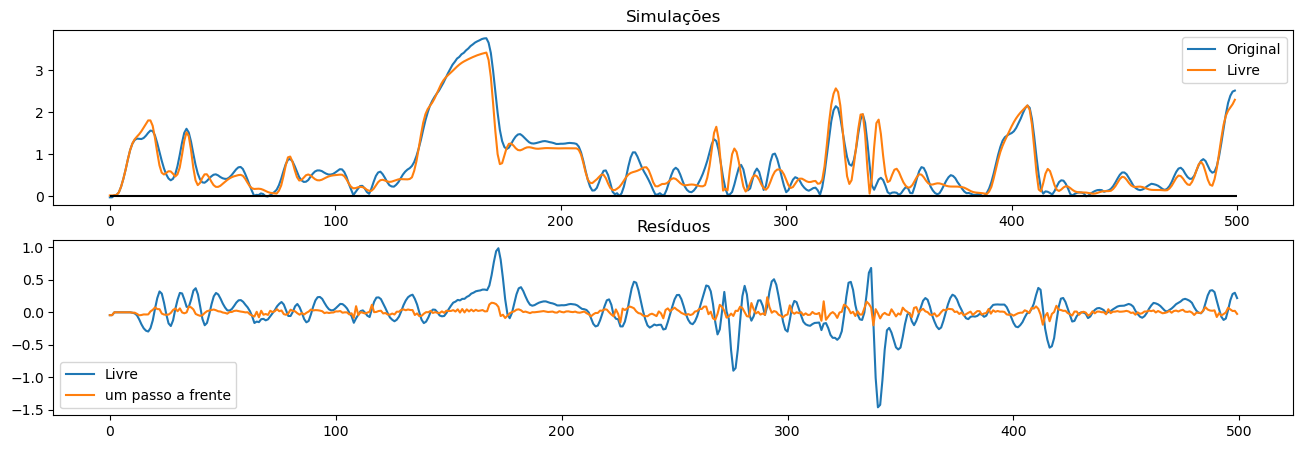

'\nSimulação livre\nRMSE: 0.1068 \nMSE: 0.0114 \nAET: 38.5658 \nMAPE: 29.081%\n'

In [60]:
uVal = u12.T
yVal = z12.T

yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(yValHat))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(np.abs(yValHat), label='hat')
ax[0].plot(np.abs(valLivre), label='Livre')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()

'''
Simulação livre
RMSE: 0.1068 
MSE: 0.0114 
AET: 38.5658 
MAPE: 29.081%
'''

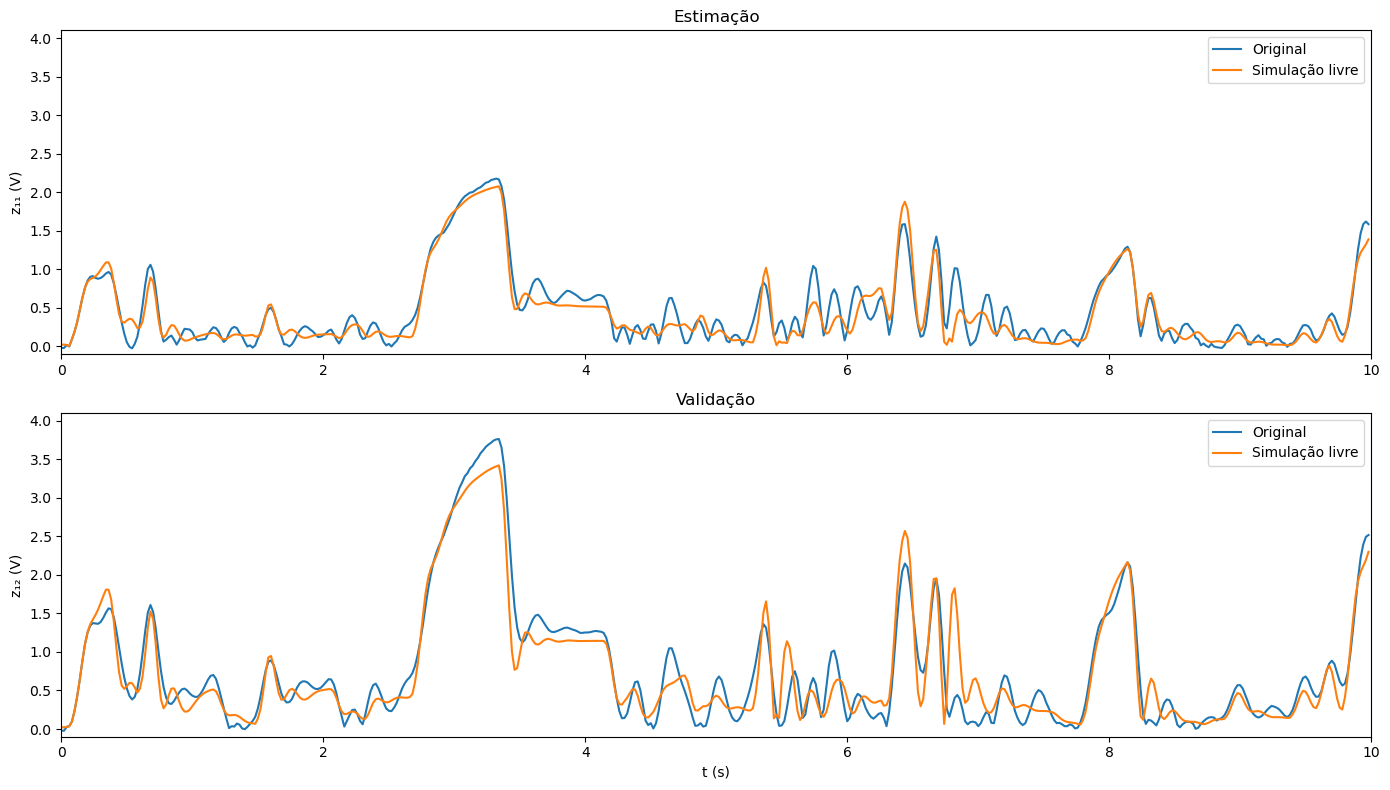

In [61]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), label='Simulação livre')
ax[0].set_ylabel('z\u2081\u2081 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_xlim(0, 10)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), label='Simulação livre')
ax[1].set_ylabel('z\u2081\u2082 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_xlim(0, 10)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesResult.png')

plt.show()

## polinomial sem não linearidades adicionais

### N abs

[Y1.1 Y1.2 U1.4*U1.7 U1.3*U1.4 U1.10*U1.8 Y1.4 U1.10*U1.7*U1.8] [ 1.78152089 -1.0498781   0.02153936  0.01250092 -0.01430109  0.21061893
  0.00403322] 7
0.00403*U1.10*U1.7*U1.8 - 0.0143*U1.10*U1.8 + 0.0125*U1.3*U1.4 + 0.02154*U1.4*U1.7 + 1.78152*Y1.1 - 1.04988*Y1.2 + 0.21062*Y1.4


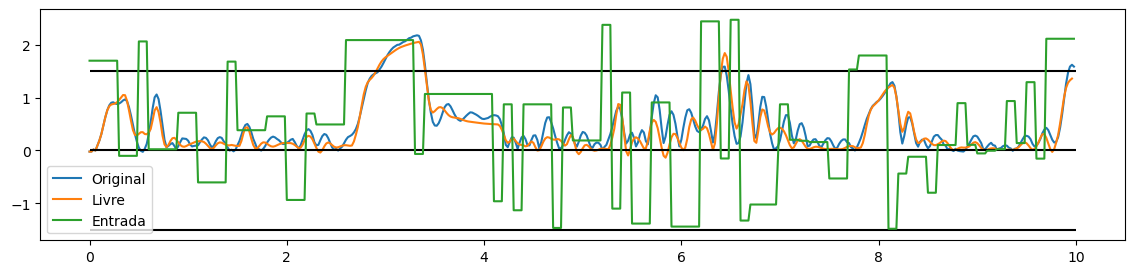


Simulação livre
RMSE: 0.1619 
MSE: 0.0262 
AET: 60.3447 
MAPE: 112.427%
Coeficiente de correlação: 0.952225763020333

Um passo a frente
RMSE: 0.0434 
MSE: 0.0019 
AET: 15.1311 
MAPE: 54.582%
Coeficiente de correlação: 0.996069355094702


In [62]:
output = 0  # 0 ou 1

y = z11.copy()
u = u11.copy()
num = [8, 6]
params = []
params.append({'nb':[10],'na':[10], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':0, 'diff':False}) #9

#params.append({'nb':[6],'na':[8], 'level':2, 'nonlinear':[0,0,0,1,0], 'root':False, 'delay':0, 'diff':False}) #9

sselector = structureSelector()
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(u.T, y.T, **params[output], dt=0.1)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, y[pad:, output], num[output], 0.00000001)
theta = LSM(y[pad:, output], psi)
model = ss[selected]

print(model, theta, len(model))
print(model @ np.round(theta, 5))

polinomial_slivre = sselector.predict(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)
polinomial_yhat = sselector.oneStepForward(u.T, y.T, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=0.1, intg=False)


fim = -1
s = 0#t-20
ts = np.arange(0, 10, 0.02)
plt.figure(figsize=(14,3))
plt.plot(ts, y, label='Original')
#plt.plot(ts[s:fim], yhat[s:fim], label='um passo a frente')
plt.plot(ts[s:fim], polinomial_slivre[s:fim], label='Livre')
plt.hlines([1.5, 0, -1.5], 0, 10, colors='black')
plt.plot(ts, u, label='Entrada')
plt.legend()
plt.show()

print("\nSimulação livre")
metrics(y[:, 0], polinomial_slivre)
print("\nUm passo a frente")
metrics(y[:, 0], polinomial_yhat)

Modelo selecionado:
0.004⋅U1.10⋅U1.7⋅U1.8 - 0.0143⋅U1.10⋅U1.8 + 0.0125⋅U1.3⋅U1.4 + 0.0215⋅U1.4⋅U1.
7 + 1.7815⋅Y1.1 - 1.0499⋅Y1.2 + 0.2106⋅Y1.4

Simulação livre
RMSE: 0.1988 
MSE: 0.0395 
AET: 74.7879 
MAPE: 90.905%
Coeficiente de correlação: 0.9691644525677172

Um passo a frente
RMSE: 0.0422 
MSE: 0.0018 
AET: 14.8079 
MAPE: 27.653%
Coeficiente de correlação: 0.9986308585111038


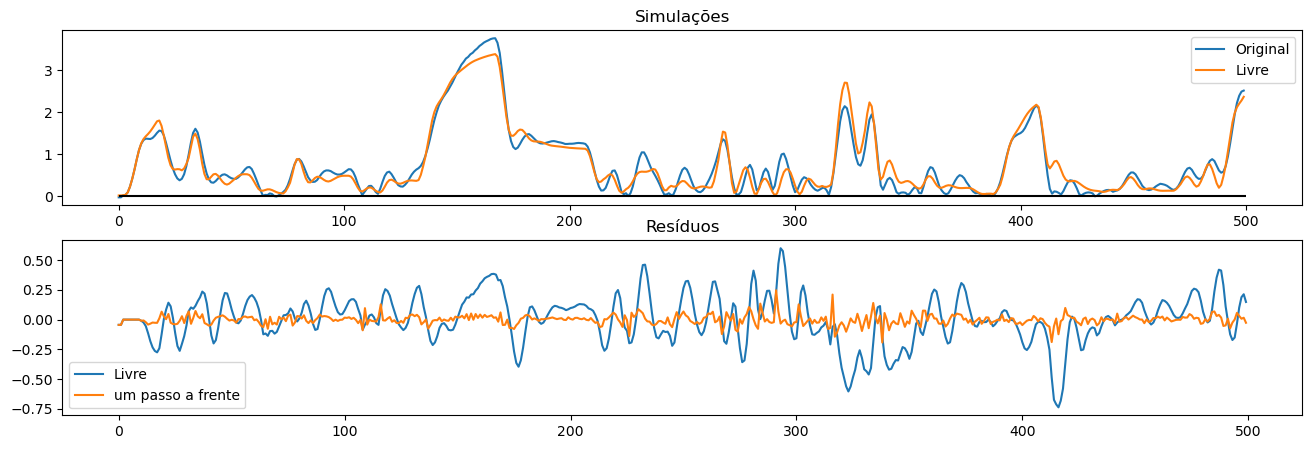

In [63]:
uVal = u12.T
yVal = z12.T

polinomial_yValHat = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output)
polinomial_valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1, intg=False)

print("Modelo selecionado:")
pprint( model @ np.round(theta, 4))

print("\nSimulação livre")
metrics(yVal[0, :], np.abs(polinomial_valLivre))
print("\nUm passo a frente")
metrics(yVal[0, :], np.abs(polinomial_yValHat))

f, ax = plt.subplots(2, 1, figsize=[16,5])
ax[0].plot(yVal[output].T, label='Original')
#ax[0].plot(polinomial_valLivre, label='Livre')
ax[0].plot(np.abs(polinomial_valLivre), label='Livre')
#ax[0].plot(polinomial_yhat, label='um passo a frente')
ax[0].hlines(0, 0, 500, colors='black')
ax[0].set_title("Simulações")
ax[0].legend()


ax[1].plot(yVal[output].T - np.abs(polinomial_valLivre), label='Livre')
ax[1].plot(yVal[output].T - np.abs(polinomial_yValHat), label='um passo a frente')
ax[1].set_title("Resíduos")
ax[1].legend()
plt.show()



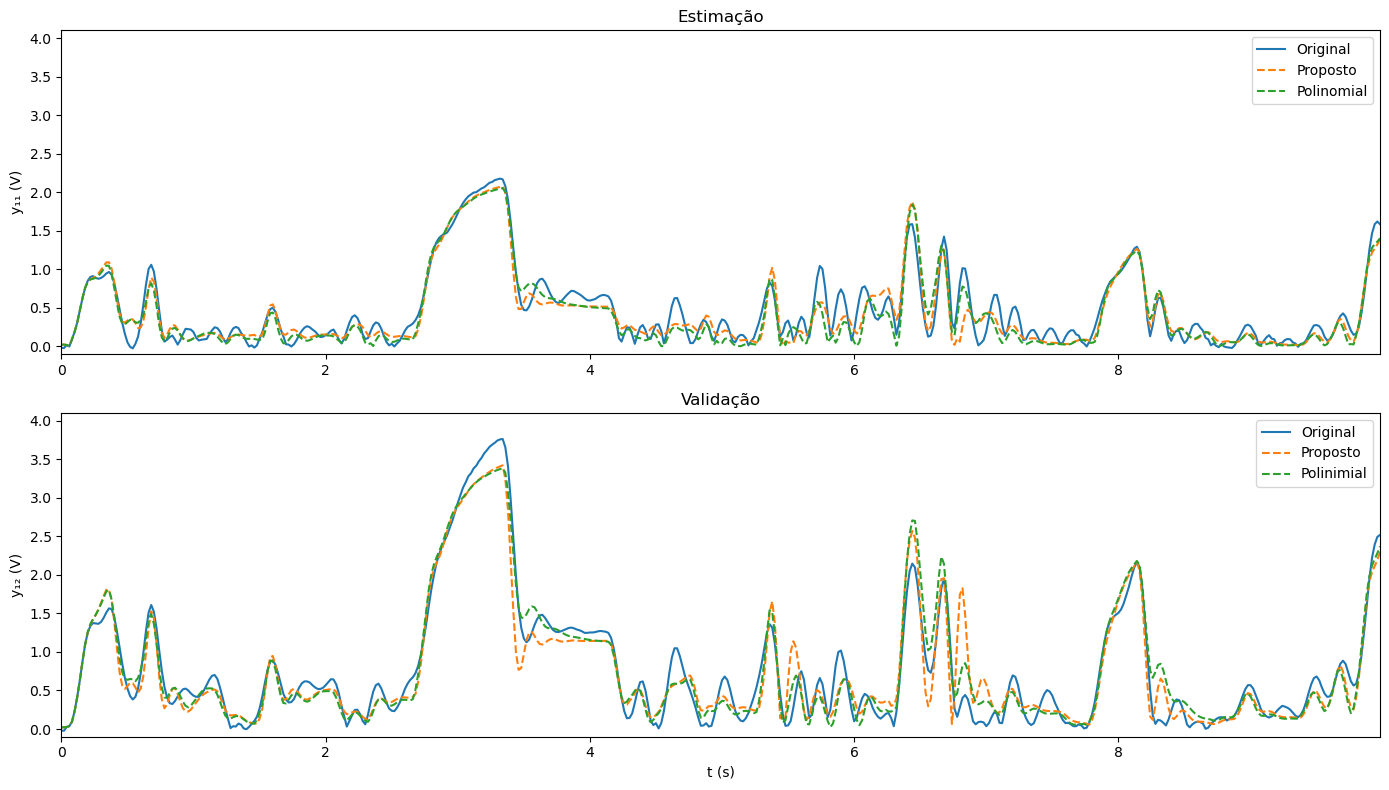

In [64]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(p, z11, label='Original')
ax[0].plot(p, np.abs(slivre), '--', label='Proposto')
ax[0].plot(p, np.abs(polinomial_slivre), '--', label='Polinomial')

ax[0].set_ylabel('y\u2081\u2081 (V)')
ax[0].set_ylim(-0.1, 4.1)
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(p, z12, label='Original')
ax[1].plot(p, np.abs(valLivre), '--', label='Proposto')
ax[1].plot(p, np.abs(polinomial_valLivre), '--', label='Polinimial')
ax[1].set_ylabel('y\u2081\u2082 (V)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.1, 4.1)
ax[1].set_title("Validação")
ax[1].legend()

ax[0].set_xlim(0, 9.98)
ax[1].set_xlim(0, 9.98)
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesComparate.png')

plt.show()

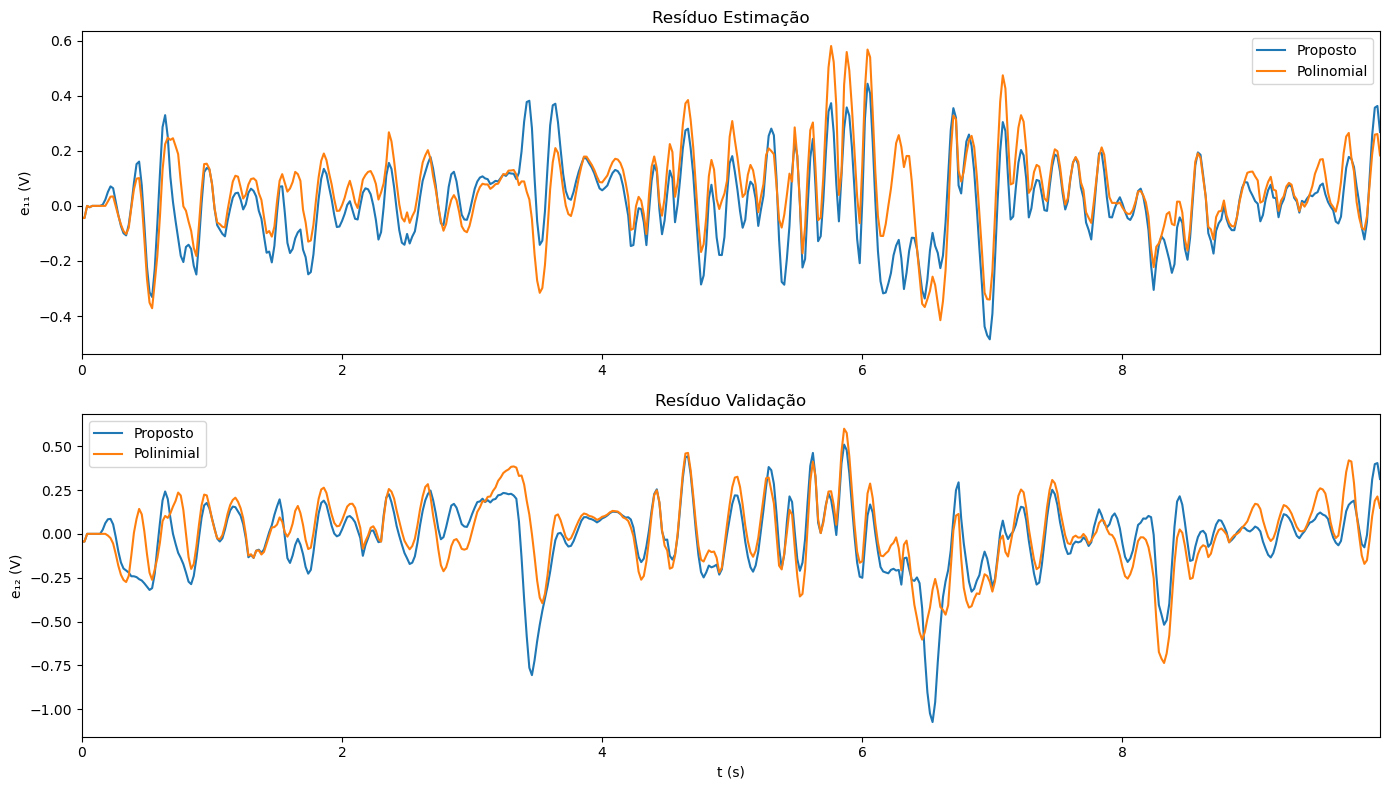

In [17]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 8])

ax[0].plot(p, z11[:,0] - np.abs(slivre), label='Proposto')
ax[0].plot(p, z11[:,0] - np.abs(polinomial_slivre), label='Polinomial')

ax[0].set_ylabel('e\u2081\u2081 (V)')
ax[0].set_title("Resíduo Estimação")
ax[0].legend()

ax[1].plot(p, z12[:,0] - np.abs(valLivre), label='Proposto')
ax[1].plot(p, z12[:,0] - np.abs(polinomial_valLivre), label='Polinimial')
ax[1].set_ylabel('e\u2081\u2082 (V)')# "x\u00b2 + y\u00b2 = 2"
ax[1].set_xlabel('t (s)')
ax[1].set_title("Resíduo Validação")
ax[1].legend()

ax[0].set_xlim(0, 9.98)
ax[1].set_xlim(0, 9.98)
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/coupledrivesResiduo.png')

plt.show()